In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.ar_model import AutoReg

from sys import stdout
from time import sleep

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#E5E5E5',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': True,
          'axes.grid.axis': 'bo

In [3]:
train = pd.read_parquet('data/train.parquet')
test = pd.read_parquet('data/test.parquet')
sample_sub = pd.read_csv('data/sample_submission.csv')

train.head(10)

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
5,59504,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[0.08, 0.88, 1.46, 0.59, -0.97, -0.41, 0.78, -...",0.0
6,49554,"[2016-04-01, 2016-05-01, 2016-06-01, 2016-07-0...","[1.05, -0.28, 1.09, -0.69, 1.26, 1.79, 1.38, -...",0.0
7,58344,"[2016-12-01, 2017-01-01, 2017-02-01, 2017-03-0...","[-0.36, -0.45, -0.4, -0.4, -0.45, -0.45, -0.45...",0.0
8,87449,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.92, 4.11, 3.39, -1.17, -0.79, 2.15, -0.22, ...",1.0
9,43415,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-0.86, -0.05, -0.35, -0.67, -0.25, -0.8, -0.6...",1.0


In [4]:
sample_sub.head(10)

,id,score
0,6125.0,0.757097
1,26781.0,0.346173
2,13333.0,0.431305
3,53218.0,0.847472
4,84204.0,0.065298
5,69997.0,0.689232
6,99301.0,0.025703
7,4361.0,0.461261
8,46607.0,0.293316
9,29836.0,0.233549


---

Посмотрим, какого размера данные и есть ли в них пропуски

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20000 non-null  int64 
 1   dates   20000 non-null  object
 2   values  20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


Пропусков не найдено, но есть интересная деталь. Поскольку столбцы с датами и значениями содержат массивы, то можно реструктурировать данные и создать альтернативную таблицу, где под каждую дату можно выделить отдельный признак. Одна строка такой таблицы будет выглядеть примерно так.

In [7]:
one = pd.DataFrame(
    index = ['1'],
    columns = train.loc[0, 'dates'], 
    data = train.loc[0, 'values'].reshape(1, -1)
)

one

,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,...,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01
1,-1.86,0.79,1.4,0.15,0.0,-1.24,-1.46,3.49,1.2,1.93,...,-1.67,-1.47,0.52,-0.77,1.2,-0.28,0.89,0.35,-0.51,-0.57


Потом в таблицу будут добавляться все новые значения. Так будут выглядеть на графике первые 2 строки.

<AxesSubplot: >

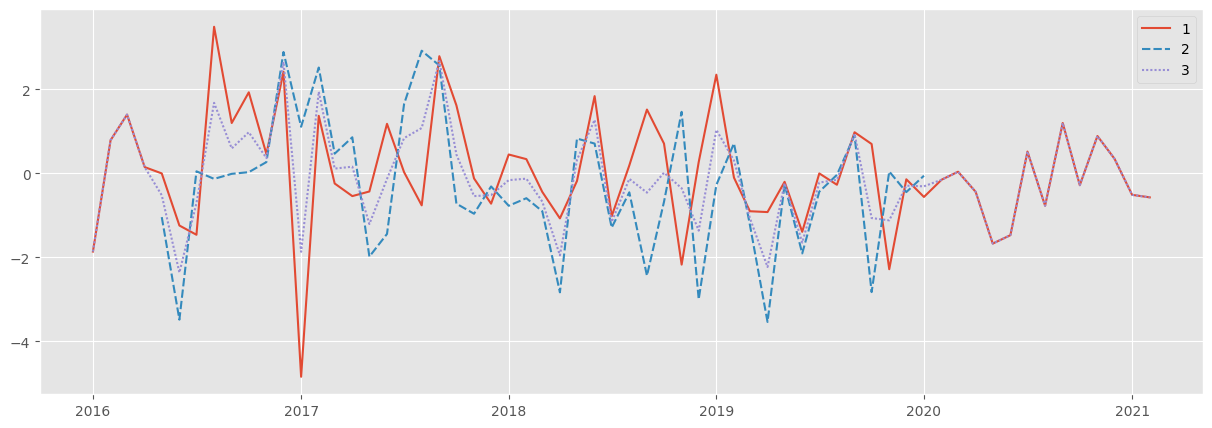

In [8]:
two = pd.DataFrame(
    index = ['2'],
    columns = train.loc[1, 'dates'], 
    data = train.loc[1, 'values'].reshape(1, -1)
)

three = pd.concat([one, two])
three.loc['3'] = three.median(axis=0)

sns.lineplot(three.T)

Как видим, первая и вторая строки имеют неодинаковую длину, так как наблюдения начинаются и заканчиваются в разное время. Следовательно второй временной ряд нужно дополнить новыми наблюдениями, то есть спрогнозировать их.

In [9]:
data = pd.concat([train, test], ignore_index=True)
lens = data['dates'].apply(lambda x: len(x)).sort_values().index[[0, -1]]

shortest = data.loc[lens[0], 'dates']
longest = data.loc[lens[1], 'dates']

len(shortest), len(longest)

(36, 97)

In [10]:
earliest = data['dates'].apply(lambda x: min(x)).sort_values().iloc[0]
latest = data['dates'].apply(lambda x: max(x)).sort_values().iloc[-1]

earliest, latest

(datetime.date(2016, 1, 1), datetime.date(2024, 1, 1))

In [11]:
def restructure_data(data):
    newdf = pd.DataFrame()
    
    for i in data.index: 
        newrow = pd.DataFrame(
            index=[i],
            columns=data.loc[i, 'dates'], 
            data=data.loc[i, 'values'].reshape(1, -1))
        
        #newrow['label'] = data.loc[i, 'label']
        
        newdf = pd.concat([newdf, newrow])
        
        stdout.write(f"\r{i}")
        stdout.flush()
        sleep(0.0001)
    
    return newdf


test['label'] = -1
data = pd.concat([train, test], ignore_index=True)

re_data = restructure_data(data) 

re_data

99999

,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,...,2023-04-01,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01
0,-1.86,0.79,1.40,0.15,0.00,-1.24,-1.46,3.49,1.20,1.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,-1.04,-3.48,0.05,-0.13,-0.01,0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.33,0.58,1.10,-0.56,-0.95,-0.61,-0.70,-1.35,-0.77,-0.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.31,0.50,-0.54,0.95,0.65,0.83,-1.55,-0.28,-1.24,0.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,NaN,NaN,3.01,-0.58,1.55,0.48,-0.35,1.93,3.86,2.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99996,0.66,1.30,2.78,-0.25,-1.97,-0.55,-1.08,-1.55,-2.62,0.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
